# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Definition

## Problem Definition
Starbucks wants to save money by controlling the offers sent to customers. 
Some customers make purchases and they are not even aware of the offer sent. But as they have spent the required amount, they get the reward by default. 
Some customers receive offers that they cannot complete e.g. they are expected to spend a lot of money or spend money is a short duration.
There are multiple challenges with this rewards program data as:
- Customers can make purchases without receiving any offers
- Customers do not opt into the offers that they receive
- Not all offers are sent to all customers
- Not all customers receive offers during certain weeks
- Not all transactions are made to avail the offers
- Customers can get same offer again within the duration of 1st offer received and get benefit of completing both offers
- Transactions are not associated with any offer

## Proposed Solution
To enable Starbucks to save cost / earn money:
- Identify customer segments that will make purchases without even looking at the offers. Do not send them any BOGO or Discount offers.
- Identify customer segments that react best to certain offers. Do not send offers that they will not be interested in.
- Use targeted marketing, lure both existing & new customers to make purchases by sending offers that they will be influenced with and in-turn Starbucks make more business.

## Approach

### I. Perform Customer Segmentation
Divide the customers in various segments
1. <b><i>Default Buyers</i></b> - Customers who anyway will make purchase irrespective of the offer sent. Starbucks can stop sending offers to these customers and make savings.
2. <b><i>Offer Lovers</i></b> - Customers who will use most of the offers sent to them. Starbucks can continue sending offers to these customers to keep them going.
3. <b><i>Target Customers</i></b> - Customers who do not fall in the above 2 segments. Starbucks can send better offers to these customers and tempt them to make more purchases.

### II. Analyse Customer Demographic 
Study the demographic details of various customer segments

### III. Build Machine Learning Model
Build a model that Starbucks can use, that suggests offers to be sent to the tartget customers or any customer existing or new.

# Analysis

## Step 1 - Data Exploration

In [82]:
#! pip install sklearn_evaluation
import pandas as pd
import numpy as np
import math
import json
import time
from sklearn_evaluation.plot import grid_search
from tqdm import tqdm
from prettytable import PrettyTable
from IPython.display import Markdown
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report 
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import preprocessing
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

% matplotlib inline

# Funtion to print strings in bold
def printmd(string):
    display(Markdown(string))

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


In [3]:
def perform_exploratory_analysis(df, df_name, id_col_names=['id']):
    '''
    This function prints the Report for the following exploratory anaysis on the given dataframe:
    1. Row count
    2. Columns with missing values
    3. Duplicate row count based on id_col_names
    4. Displays the first 5 rows
    
    INPUT
    df - Dataframe to be explored
    df_name - Name of the dataframe to be displayed in the report
    id_col_name - Name of the id column/s that you want to do the duplicate test on
    
    OUTPUT
    None
    '''
    #Row count
    rows = df.shape[0]
    
    #Identify columns with missing values
    cols_with_missing_values = []
    for col, cnt in df.isnull().sum().items():
        if(cnt > 0):
            cols_with_missing_values.append((col,cnt))
    
    #Identify duplicate rows based on the id_col_names
    duplicate = 0
    result =  all(elem in df.columns for elem in id_col_names)

    if result:
        duplicate = df.duplicated(subset=id_col_names).sum()
    else:
        duplicate ='one or more column/s not in dataframe'
    
    pd.set_option('expand_frame_repr', False)
    printmd('**--------------------------------------------------------------------------------------Exploring {}--------------------------------------------------------------------------------------**'.format(df_name))
    print('1. Row count:',rows)
    print('2. Columns with missing values:',cols_with_missing_values)
    print('3. Duplicate row count:',duplicate)
    print('4. First 5 rows:')
    display(df.head(5))
    printmd('**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**'.format(df_name))


In [4]:
perform_exploratory_analysis(portfolio,'portfolio')

**--------------------------------------------------------------------------------------Exploring portfolio--------------------------------------------------------------------------------------**

1. Row count: 10
2. Columns with missing values: []
3. Duplicate row count: 0
4. First 5 rows:


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

<b>Analysis</b> - portfolio dataset has 10 rows of offer details with no missing values and no duplicate rows. 
Data munging requirements:
- The id columns contains alpha-numeric data. Use LabelEncoder to convert id column to have numeric value for ease of analysis. 
- There are 4 possible values for channels namely 'web', 'email', 'mobile' and 'social'. Use MultiLabelBinarizer to one-hot encode channels column.
- There are 3 possible values for offer_type 'BOGO', 'Discount', 'Informational'. One-hot encode offer_type column during model implementation

In [5]:
perform_exploratory_analysis(profile,'profile')

**--------------------------------------------------------------------------------------Exploring profile--------------------------------------------------------------------------------------**

1. Row count: 17000
2. Columns with missing values: [('gender', 2175), ('income', 2175)]
3. Duplicate row count: 0
4. First 5 rows:


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

<b>Analysis</b> - profile dataset has 17000 rows of customer details with no duplicate rows. 
Data munging requirements:
- The id columns contains alpha-numeric data. Use LabelEncoder to convert id column to have numeric value for ease of analysis.
- Perform data wrangling for the column 'became_member_on' to convert it into number of years a person is a member.
- The gender and income columns have missing values, analyse and take appropriate action
- Add columns age_bin and income_bin to bin the data for better plotting
- The gender column has 3 values M,F, O. Gender O is just 1%, to keep things simple drop the rows with gender O.

In [6]:
perform_exploratory_analysis(transcript,'transcript',['person','event','time'])

**--------------------------------------------------------------------------------------Exploring transcript--------------------------------------------------------------------------------------**

1. Row count: 306534
2. Columns with missing values: []
3. Duplicate row count: 2962
4. First 5 rows:


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

<b>Analysis</b> - transcript dataset has 306534 rows of transaction and event details with no missig values.
Data munging requirements:
1. We need to do some data wrangling for the column 'value' to split the dict into multiple columns

## Step 2 - Data Munging 

### Portfolio Dataset

In [7]:
# One hot encode the channels column
mlb = MultiLabelBinarizer()

if 'channels' in portfolio.columns:
    portfolio = portfolio.join(pd.DataFrame(mlb.fit_transform(portfolio.pop('channels')),
                          columns=mlb.classes_,
                          index=portfolio.index))

In [8]:
# Label encode the id column as offer_id
le_portfolio = preprocessing.LabelEncoder()
portfolio.rename(columns={'id':'offer_id'}, inplace=True)
portfolio_ids = list(portfolio['offer_id'])
portfolio_ids.append('z_no_offer') #to take care of Nan's during encoding
le_portfolio.fit(portfolio_ids)
portfolio['offer_id'] = le_portfolio.transform(portfolio['offer_id'])

#reorder the columns for ease of analysis
portfolio = portfolio[['offer_id','offer_type','difficulty','duration','reward','email','mobile','social','web']]
portfolio

,offer_id,offer_type,difficulty,duration,reward,email,mobile,social,web
0,7,bogo,10,7,10,1,1,1,0
1,4,bogo,10,5,10,1,1,1,1
2,3,informational,0,4,0,1,1,0,1
3,6,bogo,5,7,5,1,1,0,1
4,0,discount,20,10,5,1,0,0,1
5,1,discount,7,7,3,1,1,1,1
6,9,discount,10,10,2,1,1,1,1
7,5,informational,0,3,0,1,1,1,0
8,8,bogo,5,5,5,1,1,1,1
9,2,discount,10,7,2,1,1,0,1


### Profile Dataset

In [9]:
# Derive the membership_in_years column from became_member_on column to get the number of years since the person is a member
profile.rename(columns={'became_member_on':'membership_years'}, inplace=True)

profile['membership_years'] = pd.to_datetime(profile['membership_years'], format="%Y%m%d")

# Let's add a column for the number of days elapsed since the person became a member
profile['membership_years'] = np.floor((pd.to_datetime('now') - pd.to_datetime(profile['membership_years'])) / np.timedelta64(1, 'D')/365)

profile.head()

,age,membership_years,gender,id,income
0,118,2.0,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,1.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,0.0,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,1.0,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
#Let's look at the missing values in profile dataset.
print('rows with age 118!!!:',profile[profile['age'] == 118]['age'].count())

print('Age where both gender and income are missing in profile:',profile[(profile['gender'].isnull()) & (profile['income'].isnull())]['age'].unique())

print('{0:.2f}'.format(profile[profile['age'] == 118]['age'].count() / len(profile) * 100),'% profiles with missing demographic data')

transcript_profile = transcript.join(profile.set_index('id'), on='person')

print('{0:.2f}'.format(transcript_profile[transcript_profile['age'] == 118].isnull()['gender'].sum()/len(transcript) * 100),'% transcrpits with missing demographic data')

rows with age 118!!!: 2175
Age where both gender and income are missing in profile: [118]
12.79 % profiles with missing demographic data
11.02 % transcrpits with missing demographic data


While analysing the profile data, I observed that some rows have age = 118, and the gender and income values are also missing in those rows. To confirm my observation, I took the row count of age = 118, which is 2175, same as the missing count of gender and income. That means these users have not filled in the 'age','gender' and 'income' columns during profile creation.

Total of @ 13% rows in profile have missing demographic data. And corresponding rows in transcript are @ 11%. These rows with age 118 and no gender or income are not of any use for analysis, moreover they will skew the analysis. My decision is to drop these rows from the profile and transcript dataset.

In [11]:
#Drop the rows with age = 118
age_118 = profile[ profile['age'] == 118]

print('Row count in profile:',profile.shape[0])
profile = profile.drop(age_118.index, axis=0, errors='ignore').reset_index(drop=True)
print('Row count in profile after dropping',len(age_118),'rows:',profile.shape[0])

t1_age_118 = transcript_profile[transcript_profile['age'] == 118]
print('Row count in transcript:',transcript.shape[0])
transcript = transcript.drop(t1_age_118.index, axis=0, errors='ignore').reset_index(drop=True)
print('Row count in transcript after dropping',len(t1_age_118),'rows:',transcript.shape[0])

Row count in profile: 17000
Row count in profile after dropping 2175 rows: 14825
Row count in transcript: 306534
Row count in transcript after dropping 33772 rows: 272762


In [12]:
# Let's put age and income in bins rather than continuous data

print('Min age -',profile['age'].min(),' Max age -',profile['age'].max())

print('Rows with age 101 -',profile[profile['age'] == 101].shape[0])

# Replace the 5 rows with age 101 by 100 - just for ease of analysis
profile.age.replace(101, 100,inplace=True)

print('After removing age 101, Min age -',profile['age'].min(),' Max age -',profile['age'].max())

#Add a column age_bin, compute the bin number using bin size 10, e.g. 0-9 - bin 10, 10-19 - bin 20 etc.
profile['age_bin'] = pd.cut(profile['age'], np.arange(0, 130, 20),labels=np.arange(20, 130, 20))

print('Age bins created -',profile['age_bin'].sort_values().unique())

Min age - 18  Max age - 101
Rows with age 101 - 5
After removing age 101, Min age - 18  Max age - 100
Age bins created - [20, 40, 60, 80, 100]
Categories (5, int64): [20 < 40 < 60 < 80 < 100]


In [13]:
print('Min income -',profile['income'].min(),' Max income -',profile['income'].max())

#Add a column income_bin, compute the bin number using bin size 10K, e.g. 30K-39K - bin 30, 30K-39 - bin 40 etc.
profile['income_bin'] = pd.cut(profile['income']/1000, np.arange(25, 120+10, 20),labels=np.arange(40, 130+10, 20))

print('Income bins created -',profile['income_bin'].sort_values().unique())
profile.head()

Min income - 30000.0  Max income - 120000.0
Income bins created - [40, 60, 80, 100, 120]
Categories (5, int64): [40 < 60 < 80 < 100 < 120]


,age,membership_years,gender,id,income,age_bin,income_bin
0,55,1.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,60,120
1,75,2.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,80,100
2,68,1.0,M,e2127556f4f64592b11af22de27a7932,70000.0,80,80
3,65,1.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,80,60
4,58,1.0,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,60,60


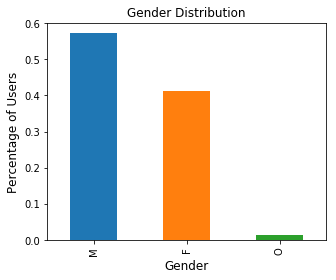

In [14]:
# Let's look at the % split of gender
profile.gender.value_counts(normalize=True).plot('bar', figsize = (5,4))
plt.title('Gender Distribution')
plt.ylabel('Percentage of Users', fontsize = 12)
plt.xlabel('Gender', fontsize = 12);

Gender O is just 1%, to keep things simple we can drop the rows with gender O

In [15]:
#Drop rows with gender O from profile as well as transcript datasets
transcript_profile = transcript.join(profile.set_index('id'), on='person')

gender_O = profile[profile['gender'] == 'O']
profile = profile.drop(gender_O.index,axis=0,errors='ignore')
print('Row count in profile after dropping gender = O rows:',profile.shape[0])

gender_O = transcript_profile[transcript_profile['gender'] == 'O']
transcript = transcript.drop(gender_O.index, axis=0, errors='ignore').reset_index(drop=True)
print('Row count in transcript after dropping gender = O rows:',transcript.shape[0])


Row count in profile after dropping gender = O rows: 14613
Row count in transcript after dropping gender = O rows: 268791


In [16]:
### Label encode the id column as person_id
le_profile = preprocessing.LabelEncoder()
profile.rename(columns={'id': 'person_id'}, inplace=True)

le_profile.fit(profile['person_id'])
profile['person_id'] = le_profile.transform(profile['person_id'])

In [17]:
# Transform the person_id column using the LableEncoder fitted on the profile
transcript.rename(columns={'person':'person_id'}, inplace=True)

transcript['person_id'] = le_profile.transform(transcript['person_id'])

In [18]:
perform_exploratory_analysis(profile,'profile',['person_id'])

**--------------------------------------------------------------------------------------Exploring profile--------------------------------------------------------------------------------------**

1. Row count: 14613
2. Columns with missing values: []
3. Duplicate row count: 0
4. First 5 rows:


,age,membership_years,gender,person_id,income,age_bin,income_bin
0,55,1.0,F,339,112000.0,60,120
1,75,2.0,F,6855,100000.0,80,100
2,68,1.0,M,12924,70000.0,80,80
3,65,1.0,M,3190,53000.0,80,60
4,58,1.0,M,2625,51000.0,60,60


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

### Transcript dataset

In [19]:
# Let's look at the unique values in the event column
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [20]:
# Let's look at the sample value column for each of the event types
pd.set_option('display.max_colwidth', -1)
display(transcript[transcript['event'] == 'offer received'][['event','value']].head(1))
display(transcript[transcript['event'] == 'offer viewed'][['event','value']].head(1))
display(transcript[transcript['event'] == 'transaction'][['event','value']].head(1))
display(transcript[transcript['event'] == 'offer completed'][['event','value']].head(1))

,event,value
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


,event,value
10862,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}


,event,value
10865,transaction,{'amount': 0.8300000000000001}


,event,value
10869,offer completed,"{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}"


<b>Analysis</b> - The 'value' column contains a dict. Note that for transcation events,value column contains amount. For 'offer received' and 'offer viewed' columns, the value column contains the offer id ('offer id). For 'offer completed' column, the value column contains the offer id ('offer_id) and reward.

Let's create separate columns for dict in the value column. Let's also combine the 'offer id' and 'offer_id' as they seem to be the same.

In [21]:
try:
    transcript = pd.concat([transcript, pd.DataFrame((d for idx, d in transcript['value'].iteritems()))], axis=1)
    transcript.loc[transcript['offer_id'].isnull(),'offer_id'] = transcript['offer id']
except:
    None
transcript = transcript.drop(['value','offer id'],axis=1,errors='ignore')

In [22]:
perform_exploratory_analysis(transcript,'transcript',['person_id','event','time','offer_id'])

**--------------------------------------------------------------------------------------Exploring transcript--------------------------------------------------------------------------------------**

1. Row count: 268791
2. Columns with missing values: [('amount', 146615), ('offer_id', 122176), ('reward', 236848)]
3. Duplicate row count: 368
4. First 5 rows:


,event,person_id,time,amount,offer_id,reward
0,offer received,6855,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,12924,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
2,offer received,3190,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,offer received,2625,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN
4,offer received,9797,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

For the new missing values introduced in transcript we can safely add 0 in the amount and reward column.

In [23]:
transcript.amount = transcript.amount.fillna(0)
transcript.reward = transcript.reward.fillna(0)

In [24]:
# Let's conver the offer_id column to numric values

# Replace Nan with 'No offer' in offer_id column
transcript['offer_id'].fillna('z_no_offer',inplace=True)

# Transform the offer_id column using the LableEncoder fitted on the portfolio.id
transcript['offer_id'] = le_portfolio.transform(transcript['offer_id'].astype(str))

# Replace the transformed 'No offer' back to Nan 
transcript.replace({'offer_id': {list(le_portfolio.classes_).index('z_no_offer'):np.nan}},inplace=True)

transcript.head()

,event,person_id,time,amount,offer_id,reward
0,offer received,6855,0,0.0,6.0,0.0
1,offer received,12924,0,0.0,2.0,0.0
2,offer received,3190,0,0.0,8.0,0.0
3,offer received,2625,0,0.0,3.0,0.0
4,offer received,9797,0,0.0,0.0,0.0


In [25]:
#There are 368 duplicate rows in transcript dataset. Let's analyse
print('Duplicate rows for event:',pd.concat(g for _, g in transcript.groupby(['person_id','offer_id','event','time']) if len(g) > 1)['event'].unique())

pd.concat(g for _, g in transcript.groupby(['person_id','offer_id','event','time']) if len(g) > 1).head(10)


Duplicate rows for event: ['offer completed']


,event,person_id,time,amount,offer_id,reward
190895,offer completed,36,504,0.0,2.0,2.0
190897,offer completed,36,504,0.0,2.0,2.0
192714,offer completed,79,510,0.0,4.0,10.0
192715,offer completed,79,510,0.0,4.0,10.0
150127,offer completed,80,420,0.0,2.0,2.0
150128,offer completed,80,420,0.0,2.0,2.0
161900,offer completed,102,444,0.0,6.0,5.0
161901,offer completed,102,444,0.0,6.0,5.0
163450,offer completed,103,450,0.0,2.0,2.0
163451,offer completed,103,450,0.0,2.0,2.0


In [26]:
#Let's look at 1 customer for offer_id 2 
transcript[transcript['person_id'] == 80]

,event,person_id,time,amount,offer_id,reward
1682,offer received,80,0,0.00,4.0,0.0
19566,offer viewed,80,24,0.00,4.0,0.0
31161,transaction,80,72,23.62,NaN,0.0
31162,offer completed,80,72,0.00,4.0,10.0
33549,transaction,80,84,22.67,NaN,0.0
36922,transaction,80,102,23.09,NaN,0.0
39960,transaction,80,120,31.71,NaN,0.0
48353,offer received,80,168,0.00,1.0,0.0
79490,offer viewed,80,234,0.00,1.0,0.0
89086,transaction,80,282,19.92,NaN,0.0


This customer received 2 offers with offer_id 2 at time 336 and 408. offer_id 2 has duration 7 so the 1st offer that was received is valid till 336 + (7* 24) = 504. This offer was viewed at 384 and transaction made on 420. So this offer received at 336 completes successfully. 
As one transaction should be attributed to only 1 offer, the 2nd offer received at 408 should not consider that transaction at 420 for it's completion. 
My decision is to delete one of the duplicate offer completed rows.

In [27]:
transcript.drop_duplicates(inplace=True)

In [28]:
transcript = transcript[['person_id','event','offer_id','amount','reward','time']]
perform_exploratory_analysis(transcript,'transcript',['person_id','event','time','offer_id'])

**--------------------------------------------------------------------------------------Exploring transcript--------------------------------------------------------------------------------------**

1. Row count: 268423
2. Columns with missing values: [('offer_id', 122176)]
3. Duplicate row count: 0
4. First 5 rows:


,person_id,event,offer_id,amount,reward,time
0,6855,offer received,6.0,0.0,0.0,0
1,12924,offer received,2.0,0.0,0.0,0
2,3190,offer received,8.0,0.0,0.0,0
3,2625,offer received,3.0,0.0,0.0,0
4,9797,offer received,0.0,0.0,0.0,0


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [29]:
#Let's look at the events that still have missing offer_ids
transcript[transcript['offer_id'].isnull()]['event'].unique()

array(['transaction'], dtype=object)

The rows with missing offer_ids are all the transaction rows. We need to fill in valid offer_ids for transactions that contributed in successful offer completion

## Step 3 - Data Engineering

To attribute a transaction to an offer, we need to analyse all the offers for valid completion. Even though the bogo and discount offers may have an 'offer complete' event, the customer may not even be aware of the offer. Informational offers do not have an offer completion event so we need to identify a criteria to attribute a transaction to informational offers.

Let's define valid offer completion:
1. For bogo and discount offers - we should have all 3 events that fall within the duration of the offer. The order of the events should be the following

offer received --> offer viewed --> offer completed

If the above condition is satisfied, we will mark all these 3 related events with a valid offer completion flag. 

For such valid offers we will identify all the transactions that fall between offer received and offer completed events, that are not yet marked with any offer id.

offer received --> transaction --> offer viewed --> transaction --> offer completed

We will add the offer id to these transactions and mark them with the valid offer completion flag.

2. For informational offers - we should have 2 events that fall within the duration of the offer. The order of the events should be the following

offer received --> offer viewed

If the above condition is satisfied, we will mark these 2 related events with a valid offer completion flag. 

For such valid offers we will identify all the transactions that are executed after the offer is viewed and offer validity period (offer received time + offer duration in hours), that are not yet marked with any offer id.

offer received --> <strike> transaction </strike>  --> offer viewed --> transaction (executed till offer validity period)

We will add the offer id to these transactions and mark them with the valid offer completion flag.

In [30]:
# Lets look at the persons with max rows
transcript[transcript['event']=='transaction'][['person_id','event']].groupby('person_id').count().sort_values(by='event',ascending=False).head(5)

,event
person_id,
6926,36
8126,36
8537,35
5385,32
10260,32


In [31]:
# Lets look at the person with max rows
print(transcript.shape,transcript[(transcript['person_id'] == 6926) ].shape)
transcript[(transcript['person_id'] == 6926) ]

(268423, 6) (48, 6)


,person_id,event,offer_id,amount,reward,time
2816,6926,offer received,9.0,0.00,0.0,0
20295,6926,offer viewed,9.0,0.00,0.0,24
29098,6926,transaction,NaN,65.80,0.0,60
29099,6926,offer completed,9.0,0.00,2.0,60
32900,6926,transaction,NaN,4.07,0.0,78
36317,6926,transaction,NaN,6.89,0.0,96
37418,6926,transaction,NaN,3.45,0.0,102
38439,6926,transaction,NaN,1.51,0.0,108
40446,6926,transaction,NaN,1.49,0.0,120
42193,6926,transaction,NaN,1.89,0.0,132


Analysis:
1. Offer_id 9 should be a valid offer as offer received, viewed, completed are present in correct order. The transaction with time 60 should get associated with this offer
2. Offer_id 2 should not be a valid offer as offer viewed event is missing. 
3. Offer id 1 should be a valid offer as offer received, viewed, completed are present in correct order. The transaction with time 348, 354, 372 should get associated with this offer.
4. Offer_id 0 should not be a valid offer as offer viewed event is missing.
5. Offer id 3 should be a valid offer as offer received, viewed are present in correct order. Offer completed event will not be there as 3 is an informatioal offer. The offer validity of offer_id 3 is 4 days (4 * 24 hrs), so the transactions between offer viewed time = 582 and offer validity = 582 + (4 * 24) = 678. So the transaction with time 594, 606, 616, 636, 666 should get associated with this offer
6. The remaining transactions should not get associated with any offer.

In [32]:
#For all customers from profile dataset
people_lst = list(profile['person_id'])  
#people_lst = [80]#Added to test 1 user for debugging
p_id = 100000000000000000#Added to test 1 user for debugging
valid_offer_completion_lst = []
valid_transaction_lst = []

#For each person identify the valid completed transactions:
#Offer received --> Offer viewed --> transactions --> Offer completed
with tqdm(total=len(people_lst)) as pbar:
    for p in people_lst:
        #Add a progress bar as this is a time consuming process
        pbar.update(1)
        
        switch_on = False
        if (p == p_id): #for debugging switch on the print statements
            switch_on = True
        
        #get all the events related to the person
        trans = transcript[(transcript['person_id']==p)]
        
        #get the corresponding offer details from portfolio df
        trans = pd.merge(trans,portfolio, on=['offer_id'], how='left')
        
        #get the offer received events for the person
        offer_rec_events = trans[trans['event']=='offer received']
        
        #Reset required variables        
        events = {'received':[],'viewed':[],'completed':[]}
        tran_lst = []
        
        # Loop thru all the offer received events
        for i,offer in offer_rec_events.iterrows():
            #Reset required variables
            is_offer_viewed = False
            offer_viewed_event = None
            is_offer_completed = False
            offer_completed_event = None
            is_offer_successful = False
            viewed_first = False
            t_completed = 0
            
            #Set reqd variables
            offer_id = offer.offer_id
            t_rec = offer.time
            
            if switch_on:
                print(offer_id,t_rec,'offer rec') 
            
            #Calculate duration of the offer in hours to make the unit same as time
            duration = offer.duration * 24
            
            # calculate the offer validaty time
            t_offer_validity = t_rec + duration
                
            #Add the time when the event was received to the events map
            events['received'].append(t_rec)
            
            # get the corresponding 'offer viewed' event if any
            offer_viewed_event = trans[(trans['offer_id'] == offer_id) & 
                                       (trans['event'] =='offer viewed') & 
                                       (trans['time'] >= t_rec) & (trans['time'] <= t_offer_validity)]['time']
                     
            if len(offer_viewed_event) > 0: # all 3 offer types should have a view event during the offer validity to be successful
                is_offer_viewed = True
                
                #As a person can receive same offer multiple times, 
                #there may be multiple 'offer viewed' events during the duration of the offer, consider the 1st one
                t_viewed = offer_viewed_event.iloc[0]
                
                if (t_viewed not in events['viewed']):
                    #Add the time when the event was viewed to the events map
                    events['viewed'].append(t_viewed)

                    if switch_on:
                        print(offer_id,t_rec,'offer viewed time within duration',t_rec,'-->',t_viewed,'-->',t_offer_validity)

                    # there may be an offer comleted event for bogo and discount offers before the offer validity period
                    if(offer.offer_type in ['bogo','discount']):
                        offer_completed_event = np.array(trans[(trans['offer_id'] == offer_id) &  
                                                               (trans['event'] == 'offer completed') & 
                                                               (trans['time'] >= t_rec) & (trans['time'] <= t_offer_validity)]['time'])
                        
                        if switch_on:
                            print(offer_id,t_rec,'offer_completed_event',offer_completed_event)
                        
                        if (len(offer_completed_event) > 0):
                            #As a person can receive the offer multiple times, 
                            #there may be multiple 'offer completed' events during the duration of the offer, consider the 1st one
                            t_completed = offer_completed_event[0]
                            
                            #offer completed should be after the offer view event
                            if (t_completed >= t_viewed):
                                is_offer_completed = True
                                viewed_first = True
                                
                                #Add the time when the event was completed to the events map
                                events['completed'].append(t_completed)

                        if (is_offer_viewed & is_offer_completed & viewed_first):
                            is_offer_successful = True
                            
                            if switch_on:
                                print(offer_id,t_rec,'is_offer_completed',t_rec,'-->',t_viewed,'-->',t_completed)
                            
                    else: 
                        #informational offer is always successful once viewed :)
                        # it is an informational offer - and all tractions between offer-viewed till the duration of offer can be attributed to it
                        is_offer_successful = True
                        t_completed = t_offer_validity
                        if switch_on:
                            print(offer_id,t_rec,'info offer infuance',t_rec,'-->',t_viewed,'-->',t_completed)

                # As we now have identified all corresponding events in correct order, let's identify transactions for that offer
                if(is_offer_successful):
                    transactions = trans[(trans['event']=='transaction') & (trans['time'] >= t_viewed)]
                    atleast_one_transaction = False
                    for i,t in transactions.iterrows():    
                        if not any((lst.get('time', None) == t.time) for lst in tran_lst):
                            if (t['time'] >= t_rec) & (t['time']<=t_completed):
                                #print('tran time',t.time)
                                atleast_one_transaction = True
                                
                                if switch_on:
                                    print(offer_id,t_rec,'Associated Trans',t['time'])
                                tran_lst.append({'event':'transaction','person_id':p,'time':t['time'],'offer_id':offer_id,'valid_offer_completion':1})

                    if(atleast_one_transaction):
                        if switch_on:
                            print(offer_id,t_rec,'offer successful')

                        valid_offer_completion_lst.append({'event':'offer received','offer_id':offer_id,'time':t_rec,'person_id':p,'valid_offer_completion':1})
                        valid_offer_completion_lst.append({'event':'offer viewed','offer_id':offer_id,'time':t_viewed,'person_id':p,'valid_offer_completion':1})
                        if(offer.offer_type in ['bogo','discount']):
                            valid_offer_completion_lst.append({'event':'offer completed','offer_id':offer_id,'time':t_completed,'person_id':p,'valid_offer_completion':1})
        
        valid_transaction_lst.extend(tran_lst)
        if switch_on:
            print('offers',valid_offer_completion_lst)
            print('trans',valid_transaction_lst)
            print('events',events)

100%|██████████| 14613/14613 [07:03<00:00, 34.52it/s]


In [33]:
# add the valid_offer_completion to the offers
if(len(valid_offer_completion_lst)>0):
    valid_offer_completion_df = pd.DataFrame(valid_offer_completion_lst)
    transcript = transcript.merge(valid_offer_completion_df,on=(['person_id','offer_id','time','event']),how='left')

In [34]:
transcript.head()

,person_id,event,offer_id,amount,reward,time,valid_offer_completion
0,6855,offer received,6.0,0.0,0.0,0,1.0
1,12924,offer received,2.0,0.0,0.0,0,NaN
2,3190,offer received,8.0,0.0,0.0,0,1.0
3,2625,offer received,3.0,0.0,0.0,0,NaN
4,9797,offer received,0.0,0.0,0.0,0,NaN


In [35]:
# add the offer_id and valid_offer_completion to the transactions contributing to the offer
if (len (valid_transaction_lst) > 0):
    valid_transaction_df = pd.DataFrame(valid_transaction_lst)    
    transcript = pd.merge(transcript,valid_transaction_df,on=['person_id','event','time'],how='left')

In [36]:
transcript.head()

,person_id,event,offer_id_x,amount,reward,time,valid_offer_completion_x,offer_id_y,valid_offer_completion_y
0,6855,offer received,6.0,0.0,0.0,0,1.0,NaN,NaN
1,12924,offer received,2.0,0.0,0.0,0,NaN,NaN,NaN
2,3190,offer received,8.0,0.0,0.0,0,1.0,NaN,NaN
3,2625,offer received,3.0,0.0,0.0,0,NaN,NaN,NaN
4,9797,offer received,0.0,0.0,0.0,0,NaN,NaN,NaN


In [37]:
# perform cleanup activities
# fill in the non-null values in offer_id_y into offer_id_x, drop offer_id_y column and then rename offer_id_x to offer_id
# do the same for valid_offer_completion 
try:
    transcript.loc[transcript['offer_id_x'].isnull(),'offer_id_x'] = transcript['offer_id_y']
    transcript.loc[transcript['valid_offer_completion_x'].isnull(),'valid_offer_completion_x'] = transcript['valid_offer_completion_y']
except:
    None

transcript = transcript.drop(['offer_id_y'],axis=1,errors='ignore')
transcript.rename(columns={'offer_id_x': 'offer_id'}, inplace=True)

transcript = transcript.drop(['valid_offer_completion_y'],axis=1,errors='ignore')
transcript.rename(columns={'valid_offer_completion_x': 'valid_offer_completion'}, inplace=True)

# fill in 0 for Nan in valid_offer_completion column
transcript.valid_offer_completion.fillna(0,inplace=True)

print(transcript.shape)

(268423, 7)


In [38]:
#Are there any duplicates introduced
print(transcript.shape)
try:
    display(pd.concat(g for _, g in transcript.groupby(['person_id','offer_id','event','time']) if len(g) > 1))
except:
    print('No duplicates found!!!')

(268423, 7)
No duplicates found!!!


In [39]:
perform_exploratory_analysis(transcript,'transcript',['person_id','offer_id','event','time'])

**--------------------------------------------------------------------------------------Exploring transcript--------------------------------------------------------------------------------------**

1. Row count: 268423
2. Columns with missing values: [('offer_id', 84454)]
3. Duplicate row count: 0
4. First 5 rows:


,person_id,event,offer_id,amount,reward,time,valid_offer_completion
0,6855,offer received,6.0,0.0,0.0,0,1.0
1,12924,offer received,2.0,0.0,0.0,0,0.0
2,3190,offer received,8.0,0.0,0.0,0,1.0
3,2625,offer received,3.0,0.0,0.0,0,0.0
4,9797,offer received,0.0,0.0,0.0,0,0.0


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [40]:
transcript[transcript['offer_id'].isnull()]['event'].unique()

array(['transaction'], dtype=object)

Missing offer_id values are in all the transactions that could not be associated with any valid offer.

In [41]:
# Lets look at the same person to see the valid_offer_completion flag and the offer_id associated with transactions
print(transcript.shape,transcript[(transcript['person_id'] == 6926) ].shape)
transcript[(transcript['person_id'] == 6926) ]

(268423, 7) (48, 7)


,person_id,event,offer_id,amount,reward,time,valid_offer_completion
2816,6926,offer received,9.0,0.00,0.0,0,1.0
20295,6926,offer viewed,9.0,0.00,0.0,24,1.0
29098,6926,transaction,9.0,65.80,0.0,60,1.0
29099,6926,offer completed,9.0,0.00,2.0,60,1.0
32900,6926,transaction,NaN,4.07,0.0,78,0.0
36317,6926,transaction,NaN,6.89,0.0,96,0.0
37418,6926,transaction,NaN,3.45,0.0,102,0.0
38439,6926,transaction,NaN,1.51,0.0,108,0.0
40446,6926,transaction,NaN,1.49,0.0,120,0.0
42193,6926,transaction,NaN,1.89,0.0,132,0.0


#Let's confirm our analysis:
1. Offer_id 9 should be a valid offer as offer received, viewed, completed are present in correct order. The transaction with time 60 should get associated with this offer - Correct
2. Offer_id 2 should not be a valid offer as offer viewed event is missing - Correct
3. Offer id 1 should be a valid offer as offer received, viewed, completed are present in correct order. The transaction with time 348, 354, 372 should get associated with this offer - Correct
4. Offer_id 0 should not be a valid offer as offer viewed event is missing - Correct
5. Offer id 3 should be a valid offer as offer received, viewed are present in correct order. Offer completed event will not be there as 3 is an informatioal offer. The offer validity of offer_id 3 is 4 days (4 * 24 hrs), so the transactions between offer viewed time = 582 and offer validity = 582 + (4 * 24) = 678. So the transaction with time 594, 606, 616, 636, 666 should get associated with this offer - Correct
6. The remaining transactions should not get associated with any offer - Correct

That's a job well done!!!

Now that data engineering is done, we can start working on our goals i.e. grouping the customers into different segments. For that let's add the offer and demographic data to transcript dataset.

In [42]:
# Merge transcript and portfolio datasets to add all the offer related info to the transcript
transcript = pd.merge(transcript,portfolio, on=['offer_id'], how='left')

transcript.shape

(268423, 15)

In [43]:
# Merge transcript and profile datasets to add all the demographic info to the transcript
transcript = pd.merge(transcript,profile, on=['person_id'], how='left')

transcript.head()

,person_id,event,offer_id,amount,reward_x,time,valid_offer_completion,offer_type,difficulty,duration,...,email,mobile,social,web,age,membership_years,gender,income,age_bin,income_bin
0,6855,offer received,6.0,0.0,0.0,0,1.0,bogo,5.0,7.0,...,1.0,1.0,0.0,1.0,75,2.0,F,100000.0,80,100
1,12924,offer received,2.0,0.0,0.0,0,0.0,discount,10.0,7.0,...,1.0,1.0,0.0,1.0,68,1.0,M,70000.0,80,80
2,3190,offer received,8.0,0.0,0.0,0,1.0,bogo,5.0,5.0,...,1.0,1.0,1.0,1.0,65,1.0,M,53000.0,80,60
3,2625,offer received,3.0,0.0,0.0,0,0.0,informational,0.0,4.0,...,1.0,1.0,0.0,1.0,58,1.0,M,51000.0,60,60
4,9797,offer received,0.0,0.0,0.0,0,0.0,discount,20.0,10.0,...,1.0,0.0,0.0,1.0,61,1.0,F,57000.0,80,60


Let's store the transformed dataframes to csv so that we can use them for further analysis.

In [44]:
#Checkpoint 1 - saving the datasets as csv
transcript.to_csv('transcript_processed.csv',index=False)
portfolio.to_csv('portfolio_processed.csv',index=False)
profile.to_csv('profile_processed.csv',index=False)

## Step 4 - Data Analysis and Visualization

In [45]:
#Checkpoint 1 - reading the datasets from csv
transcript = pd.read_csv('transcript_processed.csv')
portfolio = pd.read_csv('portfolio_processed.csv')
profile = pd.read_csv('profile_processed.csv')
portfolio.shape, profile.shape, transcript.shape

((10, 9), (14613, 7), (268423, 21))

If we take all the rows with event as 'offer received' we will get all the offers that were sent to all the customers. We will use this dataset for visualization

In [46]:
# Let's look at the demographic variables influancing the sucess of the offers
df_offer_received = transcript[transcript['event'] == 'offer received'].sort_values(by=['person_id','offer_type'])
df_offer_received.head()

,person_id,event,offer_id,amount,reward_x,time,valid_offer_completion,offer_type,difficulty,duration,...,email,mobile,social,web,age,membership_years,gender,income,age_bin,income_bin
134317,0,offer received,8.0,0.0,0.0,408,0.0,bogo,5.0,5.0,...,1.0,1.0,1.0,1.0,33,2.0,M,72000.0,40,80
178952,0,offer received,9.0,0.0,0.0,504,0.0,discount,10.0,10.0,...,1.0,1.0,1.0,1.0,33,2.0,M,72000.0,40,80
216916,0,offer received,2.0,0.0,0.0,576,0.0,discount,10.0,7.0,...,1.0,1.0,0.0,1.0,33,2.0,M,72000.0,40,80
49064,0,offer received,5.0,0.0,0.0,168,1.0,informational,0.0,3.0,...,1.0,1.0,1.0,0.0,33,2.0,M,72000.0,40,80
99584,0,offer received,3.0,0.0,0.0,336,1.0,informational,0.0,4.0,...,1.0,1.0,0.0,1.0,33,2.0,M,72000.0,40,80


Let's look at the some statistics

In [47]:
print('Total Successful Offers {0:.2f}%'.format(df_offer_received[df_offer_received['valid_offer_completion'] == 1].shape[0]/len(df_offer_received)*100))
print('Total Failed Offers {0:.2f}%'.format(df_offer_received[df_offer_received['valid_offer_completion'] == 0].shape[0]/len(df_offer_received)*100))

# Percentage of events receviced by offer_type
totals = round(pd.DataFrame(df_offer_received.groupby(['offer_type'])['event'].agg([('Total %','count')]) / len(df_offer_received) *100),2)
# Percentage of successful offers by offer type
successes = pd.DataFrame(df_offer_received[df_offer_received['valid_offer_completion'] == 1].groupby(['offer_type'])['event'].agg([('Success %','count')]) / len(df_offer_received)  *100)
# Percentage of unsuccessful offers by offer type
failures =  pd.DataFrame(df_offer_received[df_offer_received['valid_offer_completion'] != 1].groupby(['offer_type'])['event'].agg([('Failure %','count')]) / len(df_offer_received)  *100)

result = pd.concat([totals,successes,failures],axis=1).astype(float).reset_index()
result['Success %']=round(result['Success %']/result['Total %'] * 100,2)
result['Failure %']=round(result['Failure %']/result['Total %'] * 100,2)
print()
print('Success-Failure stats by offer type:')

display(result)


Total Successful Offers 39.59%
Total Failed Offers 60.41%

Success-Failure stats by offer type:


,offer_type,Total %,Success %,Failure %
0,bogo,39.92,37.87,62.14
1,discount,40.10,42.01,57.98
2,informational,19.98,38.17,61.84


Let's look at the ranking of offers based on success of the offers. For that let's calculate for each offer
- successful offers which is the total offers completed successfully
- failed offers which is the total offers that did not complete successfully
- positive resonse which is the percentage of offers completed successfully

In [48]:
df = df_offer_received.groupby(['offer_type','offer_id','valid_offer_completion'])['valid_offer_completion'].count().unstack().sort_values(by=['offer_id'])
df = df.reset_index(col_level=1)
df.rename(columns={0.0:'failed_offers',1.0:'successful_offers'},inplace=True)
df = df.fillna(0)
df['total_offers'] = df['successful_offers']+df['failed_offers']
df['positive_response']= round(df['successful_offers']/df['total_offers']*100,2)
# Add a rank column to see the ranking based on positive response.
df['rank'] = df['positive_response'].rank(ascending = False) 

df_offer_details = df.merge(portfolio,on='offer_id').drop(['offer_type_y'],axis=1).rename(columns={'offer_type_x':'offer_type'}).sort_values(by=['total_offers','rank'],ascending=False)

In [49]:
df_offer_details[['rank','offer_id','offer_type','difficulty','duration','reward','positive_response']].sort_values(by='rank')

,rank,offer_id,offer_type,difficulty,duration,reward,positive_response
9,1.0,9.0,discount,10,10,2,62.23
1,2.0,1.0,discount,7,7,3,58.75
5,3.0,5.0,informational,0,3,0,48.21
8,4.0,8.0,bogo,5,5,5,47.89
4,5.0,4.0,bogo,10,5,10,39.14
7,6.0,7.0,bogo,10,7,10,36.57
2,7.0,2.0,discount,10,7,2,28.67
3,8.0,3.0,informational,0,4,0,28.15
6,9.0,6.0,bogo,5,7,5,28.02
0,10.0,0.0,discount,20,10,5,18.58


### Analysis:
We can clearly see that even though offer_id 0 has been sent to most people, it is the least successful offer. The obvious reason is the difficulty factor, where a person has to spend 20 in 10 days to get the reward of 5 i.e. 25%.

The next 2 bogo offers have lower difficulty level but the duration is 7 days. This could be a possible reason that these 2 offers are lower in ranking as more the time one has to make purchases, the better.

The most successful offer is offer_id 9, which is a discount offer with diffuculty 10, duration 10 days and reward 2 i.e. 20%.

This is followed closely by another discount offer 1 with difficulty 7, duration 7 days and reward 3 i.e. more than 40%

So the thumb rule here is that offer with less difficulty, more duration and more reward is more successful.

See the chart below showing the ranking based on positive resposes.

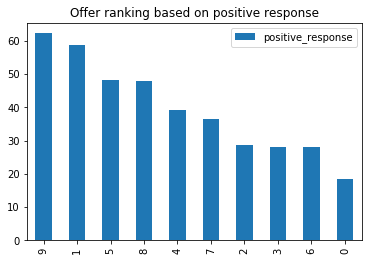

In [50]:
df_offer_details[['positive_response']].sort_values(by='positive_response',ascending=False).plot.bar(title='Offer ranking based on positive response')

Now let's see the feature importance affecting the successful offer completion. ALong with the offer features we will also see the customer demograpics ordered graphically.

Feature importance


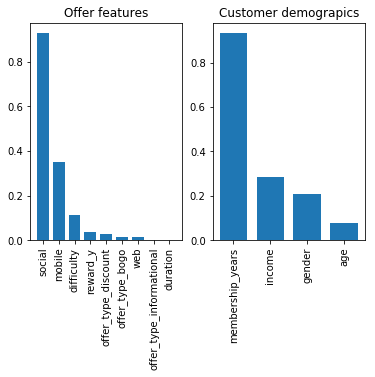

In [51]:
#Let's look at each demographic related variable by its level of association with the target, which is 'valid_offer_completion' in this case.
Selector_f = SelectPercentile(f_regression, percentile=50)

#Let's look at each offer related variable by its level of association with the target, which is 'valid_offer_completion' in this case.
df_offer_received_temp = pd.get_dummies(df_offer_received,prefix='offer_type')

X = df_offer_received_temp[['offer_type_bogo','offer_type_discount','offer_type_informational',
                      'difficulty','duration','reward_y','mobile','social','web']] # Removed email as it has all 1's and thus F-score being calculated in nan
y = df_offer_received['valid_offer_completion']
Selector_f.fit(X,y)
f_scores={}
normalized_scores = preprocessing.normalize([Selector_f.scores_])

print('Feature importance')
for n,s in zip(X.columns,normalized_scores[0]):
    f_scores[n] = s

normalized_scores = sorted(f_scores.items(), key=lambda x: x[1],reverse=True)
plt.subplot(1,2,1)
plt.bar(np.arange(len(normalized_scores)),list(zip(*normalized_scores))[1],width=0.75)
plt.xticks(np.arange(len(normalized_scores)),list(zip(*normalized_scores))[0],rotation=90)
plt.title('Offer features')

df_offer_received_temp = df_offer_received.replace({'gender': {'F':0, 'M':1}})


X = df_offer_received_temp[['age', 'gender', 'income', 'membership_years']]
y = df_offer_received_temp['valid_offer_completion']
Selector_f.fit(X,y)
f_scores={}
normalized_scores = preprocessing.normalize([Selector_f.scores_])
for n,s in zip(X.columns,normalized_scores[0]):
    f_scores[n] = s

normalized_scores = sorted(f_scores.items(), key=lambda x: x[1],reverse=True)

plt.subplot(1,2,2)
plt.bar(np.arange(len(normalized_scores)),list(zip(*normalized_scores))[1],width=0.75)
plt.xticks(np.arange(len(normalized_scores)),list(zip(*normalized_scores))[0],rotation=90)
plt.title('Customer demograpics')
plt.show()

### Analysis
This suggests that channels social and mobile and most infuancing features followed by difficulty and reward. 

Similarly  membership_years is the most influancing feature in demogrphics and age is the least. 

# Implementation
## Goal 1 - Customer Segmentation 

### Step 1 - Customer segment definition
As stated in the goals - let's now define the 3 groups and divide the customers into those groups. For that let's calculate the following for each person
- successful offer summary which is the total offers completed successfully
- failed offer summary which is the total offers that did not complete successfully
- positive resonse summary which is the percentage of offers completed successfully

In [52]:
df_response_per_person = df_offer_received.groupby(['person_id','valid_offer_completion'])['valid_offer_completion'].count().unstack().sort_values(by=['person_id'])
df_response_per_person.reset_index(inplace=True)

df_response_per_person = df_response_per_person.fillna(0)

df_response_per_person.rename(columns={0.0:'failed_offers_summary',1.0:'successful_offers_summary'},inplace=True)
df_response_per_person['positive_response_summary']= np.ceil(df_response_per_person['successful_offers_summary']/(df_response_per_person['successful_offers_summary']+df_response_per_person['failed_offers_summary'])*100)

# get the demographics related to each person.
df_response_per_person = df_response_per_person.merge(profile,sort=False,on=['person_id'])


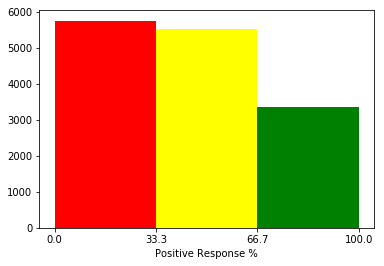

In [53]:
# let's look at the histogram of the positive reponse percentage. Let's divide it into 3 bins

fig, ax = plt.subplots()
counts, bins, patches = plt.hist(df_response_per_person['positive_response_summary'],bins=3,label='asdas')
ax.set_xticks(bins)
patches[0].set_facecolor('r')
patches[1].set_facecolor('yellow')
patches[2].set_facecolor('g')
ax.set_xlabel('Positive Response %')
plt.show()

### Step 2 - Customer Segment Creation
We can now divide the customers into 3 segments as suggested in the above figure
1. People who responded to < 33% offers. These are the people who love Starbucks :) and irrespective of the offer sent they will make purchase. Let's name this segment as <b>'Default Buyers'</b>. Starbucks need not send any bogo or discount offers to them and they still will buy the products, thus saving the cost related to the offer. Starbucks can send informational offers as that does not cost anything to Starbucks moreover these customers can try new thing and increase the business for Starbucks.

2. People who responded to >= 33% and < 67% offers. These are our <b>'Target Customers'</b>. We will build a model to suggest the offers that can be sent to them.

3. People who responded to >=67 % offers. These are the people who respond well to the offers. Let's name this segment as <b>'Offer Lovers'</b>. Starbucks need to keep sending them offers to lure them into making more purchases.

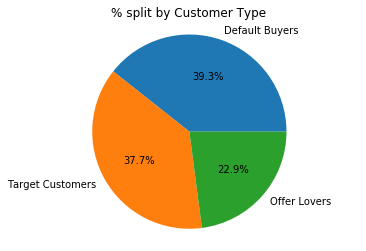

In [54]:
default_buyers = df_response_per_person[df_response_per_person['positive_response_summary'] < 33]
default_buyers.insert(0,'cust_type','default_buyers')
#display(default_buyers.head(3))

target_customers = df_response_per_person[(df_response_per_person['positive_response_summary'] >= 33) 
                                      & (df_response_per_person['positive_response_summary'] < 67)]
target_customers.insert(0,'cust_type','target_customers')

offer_lovers = df_response_per_person[df_response_per_person['positive_response_summary'] >= 67]
offer_lovers.insert(0,'cust_type','offer_lovers')

plt.pie([default_buyers.shape[0],target_customers.shape[0],offer_lovers.shape[0]],
        labels=['Default Buyers','Target Customers','Offer Lovers'], autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('% split by Customer Type')
plt.show()

We can see that there are @40% of Default Buyers, @23% of Offer Lovers and @38% of Target Customers which we can send better offers and get them to purchase more.

### Step 3 - Customer Segment Analysis and Visualization

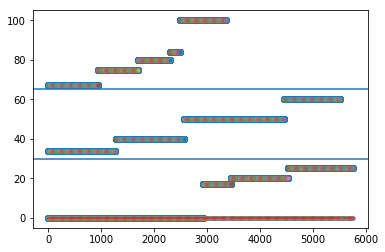

In [55]:
plt.axhline(y=30)
plt.axhline(y=65)

plt.stem(default_buyers['positive_response_summary'].sort_values(),  '.')
plt.stem(target_customers['positive_response_summary'].sort_values(),  '.')
plt.stem(offer_lovers['positive_response_summary'].sort_values(),  '.')

plt.show()

The box at the bottom has Default Buyers, middle one has Target Customers and the top one has Offer Lovers.

We can see that many of the Default Buyers have not responded to even a single offer and some of the Offer lovers have responded to all the offers.

Let's now look at the Success-Failure split for each offer type across the 3 groups

In [56]:
#Let's add the cust_type column to df_offer_received 

#Set the index to person_id 
default_buyers = default_buyers.set_index('person_id')
target_customers = target_customers.set_index('person_id')
offer_lovers = offer_lovers.set_index('person_id')

# Add the columns from default_buyers to df_offer_received - especially the cust_type
transcript_cust_type = df_offer_received.reindex(columns=df_offer_received.columns.union(default_buyers.columns))
transcript_cust_type = transcript_cust_type.set_index('person_id')

# Add the new columns
transcript_cust_type.update(default_buyers,overwrite=False)
transcript_cust_type.update(target_customers,overwrite=False)
transcript_cust_type.update(offer_lovers,overwrite=False)

#Reset the index
transcript_cust_type = transcript_cust_type.reset_index()
default_buyers = default_buyers.reset_index()
target_customers = target_customers.reset_index()
offer_lovers = offer_lovers.reset_index()
transcript_cust_type.head()

,person_id,age,age_bin,amount,cust_type,difficulty,duration,email,event,failed_offers_summary,...,offer_id,offer_type,positive_response_summary,reward_x,reward_y,social,successful_offers_summary,time,valid_offer_completion,web
0,0,33,40,0.0,target_customers,5.0,5.0,1.0,offer received,3.0,...,8.0,bogo,40.0,0.0,5.0,1.0,2.0,408,0.0,1.0
1,0,33,40,0.0,target_customers,10.0,10.0,1.0,offer received,3.0,...,9.0,discount,40.0,0.0,2.0,1.0,2.0,504,0.0,1.0
2,0,33,40,0.0,target_customers,10.0,7.0,1.0,offer received,3.0,...,2.0,discount,40.0,0.0,2.0,0.0,2.0,576,0.0,1.0
3,0,33,40,0.0,target_customers,0.0,3.0,1.0,offer received,3.0,...,5.0,informational,40.0,0.0,0.0,1.0,2.0,168,1.0,0.0
4,0,33,40,0.0,target_customers,0.0,4.0,1.0,offer received,3.0,...,3.0,informational,40.0,0.0,0.0,0.0,2.0,336,1.0,1.0


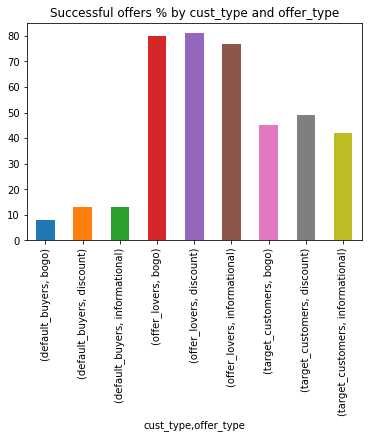

In [57]:
temp_df = transcript_cust_type.groupby(['cust_type','offer_type'])['valid_offer_completion'].sum()
temp_df_1 = transcript_cust_type.groupby(['cust_type','offer_type'])['valid_offer_completion'].count()

temp_df = round(temp_df/(temp_df_1)*100)

temp_df.plot.bar(title='Successful offers % by cust_type and offer_type')
plt.show()

We can see that Dafault Buyers success % is in early teens, that of Target Customers is close to 50% and Offer Lovers it is close to 80%.

Let's go a level deeper and see what offers are liked better

[]

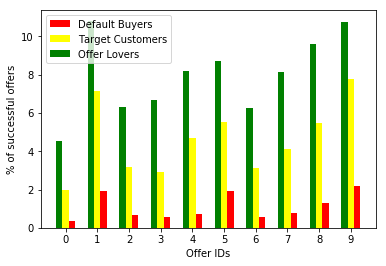

In [58]:
offer_lovers_choice = transcript_cust_type[(transcript_cust_type['cust_type'] == 'offer_lovers') &
                    (transcript_cust_type['valid_offer_completion']==1)].groupby('offer_id')['valid_offer_completion'].sum()#.sort_values(ascending=False)
offer_lovers_choice = (round(offer_lovers_choice/transcript_cust_type[(transcript_cust_type['cust_type'] == 'offer_lovers')].shape[0]*100,2))
target_customers_choice = transcript_cust_type[(transcript_cust_type['cust_type'] == 'target_customers') &
                    (transcript_cust_type['valid_offer_completion']==1)].groupby('offer_id')['valid_offer_completion'].sum()#.sort_values(ascending=False)     
target_customers_choice = (round(target_customers_choice/transcript_cust_type[(transcript_cust_type['cust_type'] == 'target_customers')].shape[0]*100,2))

default_buyers_choice = transcript_cust_type[(transcript_cust_type['cust_type'] == 'default_buyers') &
                    (transcript_cust_type['valid_offer_completion']==1)].groupby('offer_id')['valid_offer_completion'].sum()#.sort_values(ascending=False)
default_buyers_choice = (round(default_buyers_choice/transcript_cust_type[(transcript_cust_type['cust_type'] == 'default_buyers')].shape[0]*100,2))

ax = plt.subplot(111)
ax.bar(default_buyers_choice.index+0.2, default_buyers_choice,width=0.2,color='r',align='center')
ax.bar(target_customers_choice.index, target_customers_choice,width=0.2,color='yellow',align='center')
ax.bar(offer_lovers_choice.index-0.2, offer_lovers_choice,width=0.2,color='g',align='center')
ax.set_xticks(np.arange(0,10))
ax.set_xlabel('Offer IDs')


ax.set_ylabel('% of successful offers')
ax.legend(('Default Buyers','Target Customers','Offer Lovers'))
plt.plot()

We can see from the above plot that offers 9, 1, 8 are the top 3 successful offers. This matched the ranks that we saw based on the overall positive response.

## Goal 2 - Customer Demographic Analysis
Now let's plot the demographic information for the Default Buyers and Offer Lover groups

In [59]:
def plot_demographics(dfs,titles):
    # Plot Pie chart
    #count_by_age_group.plot.pie(figsize=(6, 6))
    
    #dfs=[df1,df2,df3,df4]
    fig1 = plt.figure()
    pos = 0
    for df,title in zip(dfs,titles):
        ax1 = fig1.add_axes([pos, 0, .5, .5], aspect=1)
        ax1.pie(df, labels=df.index, autopct='%1.1f%%')
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax1.set_title(title)
        pos+=.6

    plt.show()

**Membership in years**

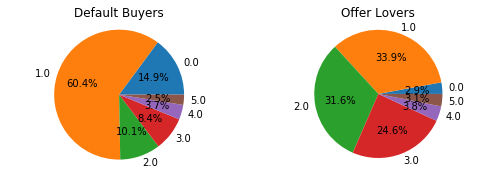

**Income in thousands**

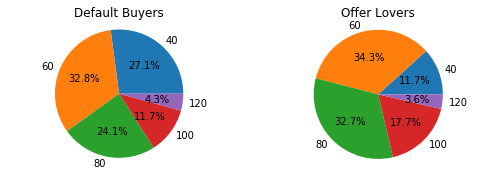

**Gender**

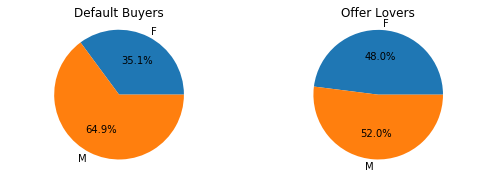

**Age**

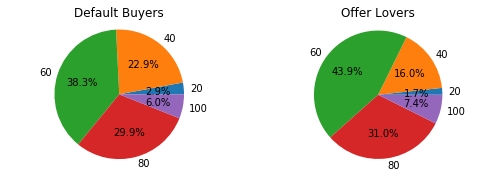

In [60]:
printmd('**Membership in years**')
plot_demographics([default_buyers.groupby(['membership_years'])['membership_years'].count(),
                  #target_customers.groupby(['membership_years'])['membership_years'].count(),
                  offer_lovers.groupby(['membership_years'])['membership_years'].count()],
                 ['Default Buyers','Offer Lovers'])

printmd('**Income in thousands**')
plot_demographics([default_buyers.groupby('income_bin')['person_id'].count(),
                  #target_customers.groupby(pd.cut((target_customers['income']/1000), np.arange(20, 120+20, 25)))['person_id'].count(),
                  offer_lovers.groupby('income_bin')['person_id'].count()],
                 ['Default Buyers','Offer Lovers'])


printmd('**Gender**')
plot_demographics([default_buyers.groupby('gender')['person_id'].count(), 
                   #target_customers.groupby('gender')['person_id'].count(), 
                   offer_lovers.groupby('gender')['person_id'].count()],
                 ['Default Buyers','Offer Lovers'])

printmd('**Age**')
plot_demographics([default_buyers.groupby('age_bin')['person_id'].count(),
                  #target_customers.groupby(pd.cut(target_customers['age'], np.arange(0, 120, 25)))['person_id'].count(), 
                  offer_lovers.groupby('age_bin')['person_id'].count()],
                 ['Default Buyers','Offer Lovers'])

### Analysis:
- Membership years - customers with 2-3 years of association tend to respond to offers better than the customers with 1 or less years of association. This is the most prominant influancing feature.
- Income - customers with lower or very higher income do not tend to respond to offers.
- Gender - males are majorly the Default Buyers. In Offer Lovers we see similar distribution of gender mix.
- Age - it is not much of a defining factor of wheather a person will respond to the offer or not.

In [61]:
def plot_demographics_for_all_offers(df,ranks):
    printmd('**Customer demographics:**')
    
    for offer in ranks:    
        temp_df = df[df['offer_id'] == offer]
        printmd('**Offer ID {} - {} offer with difficulty {}, duration {} and reward {}**'.format(offer,portfolio[portfolio['offer_id'] == offer]['offer_type'].item(),portfolio[portfolio['offer_id'] == offer]['difficulty'].item(),portfolio[portfolio['offer_id'] == offer]['duration'].item(),portfolio[portfolio['offer_id'] == offer]['reward'].item()))
        plot_demographics([ temp_df.groupby(pd.cut(temp_df['membership_years'],bins=np.arange(0,7,2),labels=np.arange(1,7,2)))['membership_years'].count(),
                            temp_df.groupby(pd.cut(temp_df['income_bin'],bins=np.arange(20,130,20),labels=np.arange(40,130,20)))['income_bin'].count(),
                           #temp_df.groupby(['income_bin'])['income'].count(),
                            temp_df.groupby('gender')['gender'].count(),
                            temp_df.groupby(pd.cut(temp_df['age_bin'],bins=np.arange(0,121,40),labels=np.arange(40,121,40)))['age_bin'].count(),
                      ], 
                     ['Membership years completed','Income in thousands','Gender','Age'])


**Customer demographics:**

**Offer ID 9 - discount offer with difficulty 10, duration 10 and reward 2**

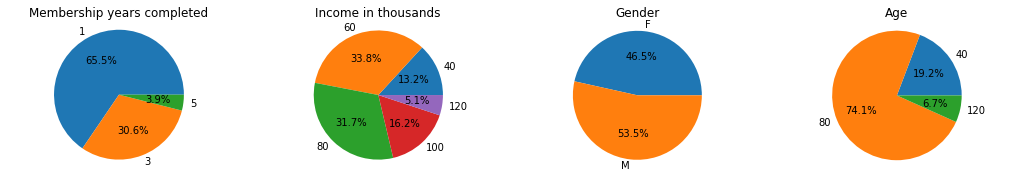

**Offer ID 1 - discount offer with difficulty 7, duration 7 and reward 3**

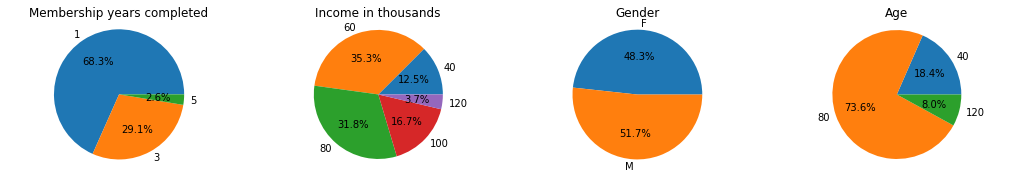

**Offer ID 5 - informational offer with difficulty 0, duration 3 and reward 0**

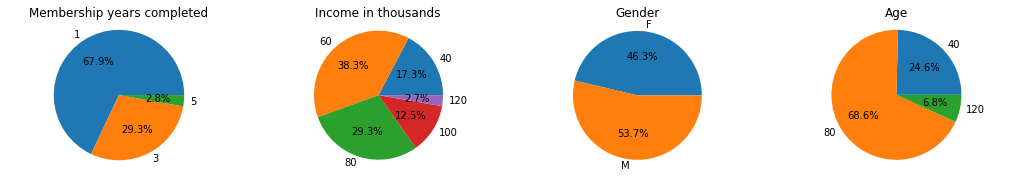

**Offer ID 8 - bogo offer with difficulty 5, duration 5 and reward 5**

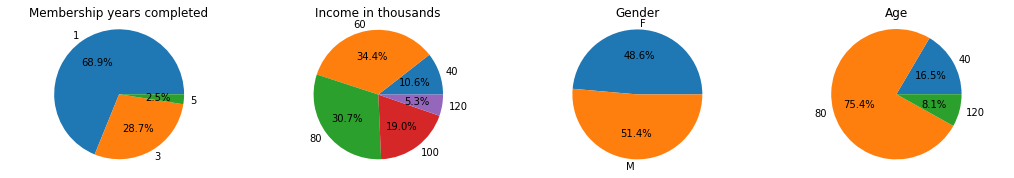

**Offer ID 4 - bogo offer with difficulty 10, duration 5 and reward 10**

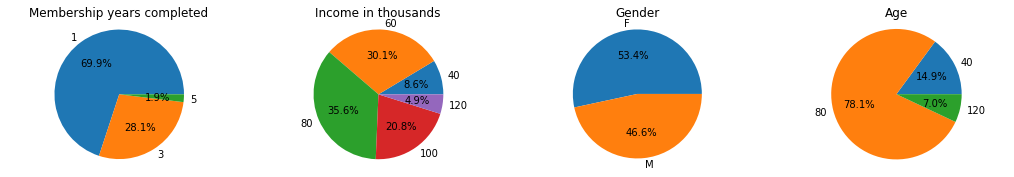

**Offer ID 7 - bogo offer with difficulty 10, duration 7 and reward 10**

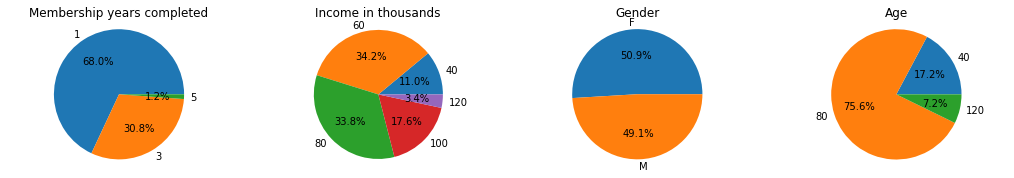

**Offer ID 2 - discount offer with difficulty 10, duration 7 and reward 2**

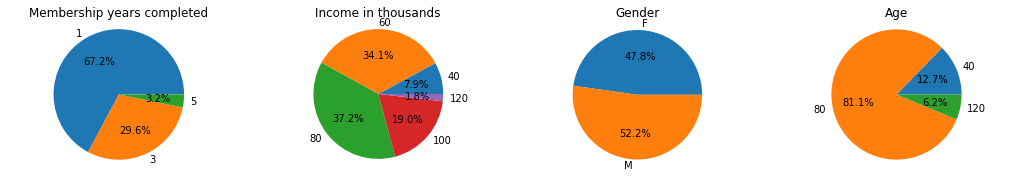

**Offer ID 3 - informational offer with difficulty 0, duration 4 and reward 0**

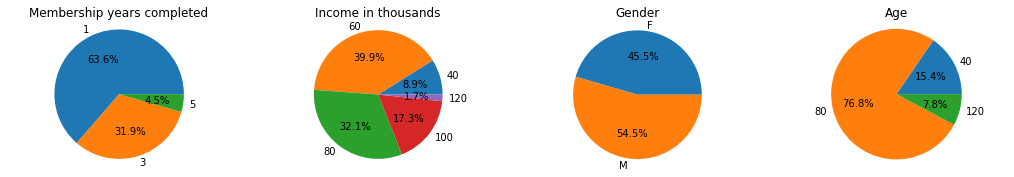

**Offer ID 6 - bogo offer with difficulty 5, duration 7 and reward 5**

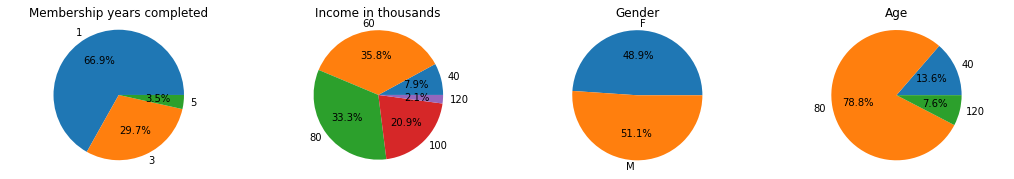

**Offer ID 0 - discount offer with difficulty 20, duration 10 and reward 5**

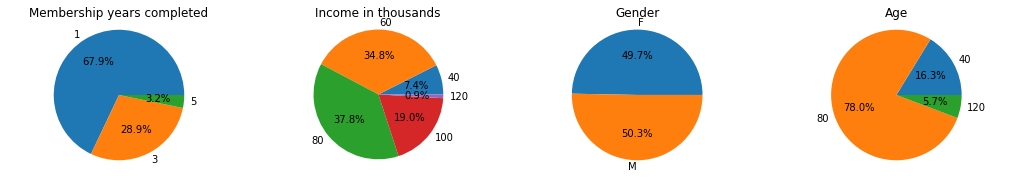

In [62]:
temp_df = transcript_cust_type[(transcript_cust_type['cust_type'] == 'offer_lovers') &
                        (transcript_cust_type['valid_offer_completion']==1) ]
#temp_df = temp_df.groupby(['person_id','offer_id']).filter(lambda x: len(x)>1)
ranked_offer = df_offer_details[['offer_type','rank']].sort_values(by=['rank'])

plot_demographics_for_all_offers(temp_df,ranked_offer.index)

### Analysis 
All the offers have similar demograhic split, so cannot make any conclusive statements.

I tried many views of the demographic data but was getting almost similar results. As it was hard to interpret manually, I decided to create a model for predicting offers that a customer will most likely complete.

## Goal 3 - Build Machine Learning Model
Let's build a machine learning model that will predict the offers that a customer will most likely avail.
This is a typical Binary Classification problem where we need to classify if a person will complete an offer successfully or not. 
- Compare 5 classifiers to identify the best model 
- Fine tune the hyper-parameters of the selected model to optimize it for better prediction.
- Use the 'Offer Lovers' data to train and test the model.

### Step 1 - Data pre-processing

In [63]:
# Scale the features data
scaler = MinMaxScaler()
    
def data_preprocessing(df):
    #Drop the columns that are not useful in modeling
    df= df.drop(['person_id','offer_id','age_bin','income_bin','amount','time', 'event',
                 'reward_x','failed_offers_summary','successful_offers_summary',
                 'positive_response_summary','cust_type'],axis=1).rename(columns = {'reward_y':'reward'})

    # Conver the gender column to numeric values
    df.replace({'gender': {'F':0, 'M':1}},inplace=True)

    #One-hot encode the offer_type column
    df = pd.get_dummies(df,prefix='offer_type')
    
    # use valid_offer_completion as target variable & rest of the columns are features
    X = np.array(df.drop('valid_offer_completion',axis=1))
    y = np.array(df['valid_offer_completion'])

    X_scaled = scaler.fit_transform(X)

    return X_scaled,y

Create Train set & Test set using 'Offer Lovers' data. 

Features to be used to train the model - 'age' 'difficulty' 'duration' 'email' 'gender' 'income' 'membership_years' 'mobile' 'reward' 'social' 'web' 'offer_type_bogo' 'offer_type_discount' 'offer_type_informational'

Target variable - valid_offer_completion

In [64]:
X, y = data_preprocessing(transcript_cust_type[transcript_cust_type['cust_type'] == 'offer_lovers'])

In [65]:
# Create Features and target sets for train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42)
print('Train set size -', x_train.shape[0],', Test set size -',x_test.shape[0])

Train set size - 9998 , Test set size - 4285


### Step 2 - Model Evaluation Metrics Selection

Let's state the null and alternate Hypothesis before we build our mode. We assume that customer is not influenced by the offer and thus Starbucks has wasted the money on that offer.

- H_null - customer is not influenced by the offer to make purchase
- H_alt - customer is influenced by the offer to make purchase
<table>
    <tr>
        <td></td>
        <td>Predicted to not be influenced (N)</td>
        <td>Predicted to be influenced (P) </td> 
    </tr>
    <tr>
        <td>Actually not influenced (N) </td>
        <td>True Negative (TN)</td>
        <td>False Positive (FP)</td>
    </tr>
<tr>
        <td>Actually influenced (P)</td>
        <td>False Negative (FN)</td>
        <td>True Positive (TP)</td>
    </tr>
    </table>

We want a model that will predict all customers who will make purchases as they are influenced by the offer sent to them.
So we want a model to have least FP, i.e. the model should not predict that the customer is influenced by the offer but in reality he is not.
At the same time there should also be less of FN i.e. the model predicts that the customer is not influenced but in reality he is, thus Starbucks may loose some business there if they do not send the offer.

Precision = TP / (TP+FP) --> Predicted Results i.e. TP / (Total Predicted Positives)

Recall = TP/(TP+FN) --> Actual Results i.e. TP / (Total Actual Positives)

Thus we want a model with better precision. Precision in our case is the % of customer-offer combinations the model has correctly identify that produced successful offers.

Instead of considering accuracy (arithmetical mean) or F1-score (harmonic mean), use Fbeta-score where beta is 0.25, to get better precision.

In [66]:
#Let's evaluate different classifiers with their default parameters
classifiers = [GaussianNB(),
               KNeighborsClassifier(),#n_neighbors=25),
               DecisionTreeClassifier(),#max_depth=9),
               RandomForestClassifier(),#n_estimators=200),
               SVC()]
results = []
beta = 0.25
for obj in classifiers:
    obj.fit(x_train,y_train)
    
    predictions_train = obj.predict(x_train)
    fscore_train = round(fbeta_score(y_train,predictions_train,beta),4)
    
    predictions_test = obj.predict(x_test)
    fscore_test = round(fbeta_score(y_test,predictions_test,beta),4)
    
    results.append([obj.__class__.__name__, fscore_train, fscore_test])
    
x = PrettyTable()
x.field_names = ['Model Name','Train F-score','Test F-score']
for row in results:
    x.add_row(row)
print(x)

+------------------------+---------------+--------------+
|       Model Name       | Train F-score | Test F-score |
+------------------------+---------------+--------------+
|       GaussianNB       |     0.8234    |    0.8162    |
|  KNeighborsClassifier  |     0.8479    |    0.815     |
| DecisionTreeClassifier |     0.9901    |    0.8044    |
| RandomForestClassifier |     0.9599    |    0.8121    |
|          SVC           |     0.8111    |    0.8052    |
+------------------------+---------------+--------------+


### Analysis:
DecisionTreeClassifier & RandomForestClassifier have the train score more than 0.9. The Test score of these 2 models are slightly less than the other 3 but comparable.

A random forest is simply a collection of decision trees whose results are aggregated into one final result. Moreover it limits over-fitting without substantially increasing error due to bias.

So my decision is to go with RandomForestClassifier.<b>RandomForestClassifier</b>.


Let's also look at the confusion matrix and Precision - Recall scores for RandomForestClassifier with default setting. We can compare these baseline scores with the optimized model scores.

The default model has Train fbeta-score - 0.9614 , Test fbeta-score - 0.8086
             precision    recall  f1-score   support

        0.0       0.26      0.19      0.22       876
        1.0       0.81      0.87      0.83      3409

avg / total       0.69      0.73      0.71      4285



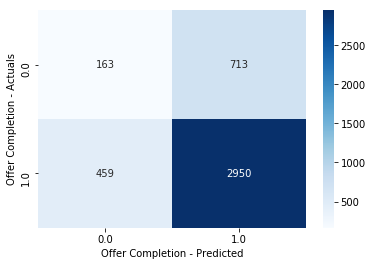

In [67]:
model = RandomForestClassifier()
model.fit(x_train,y_train)

predictions_train = model.predict(x_train)
f_score_train_baseline = round(fbeta_score(y_train,predictions_train,beta),4)

predictions_test = model.predict(x_test)
f_score_test_baseline = round(fbeta_score(y_test,predictions_test,beta),4)
print('The default model has Train fbeta-score -', round(f_score_train_baseline, 4),', Test fbeta-score -',round(f_score_test_baseline, 4))

df_confusion = pd.crosstab(y_test, predictions_test)
ax = sns.heatmap(df_confusion,cmap="Blues",annot=True,fmt="d")
ax.set(xlabel='Offer Completion - Predicted', ylabel='Offer Completion - Actuals')

print(classification_report(y_test, predictions_test))

### Step 3 - Model Tuning

Hyperparameters of Random Forest to tune:
n_estimators = n of trees
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
bootstrap = method for sampling data points (with or without replacement)

In [68]:
model = RandomForestClassifier()

#Setting the parameter options
n_estimators = [5, 10, 15]
max_features = [5, 7, 10]
max_depth = [5, 10, 20]
bootstrap = [True,False]

param_grid = [
    {'n_estimators': n_estimators, 
        'max_features': max_features, 
     'max_depth': max_depth,
    'bootstrap': bootstrap
    }
]

#We will create a scorer as fBeta scoring is not available by default
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

grid_search_forest = GridSearchCV(model, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=5)
grid_search_forest.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid=[{'n_estimators': [5, 10, 15], 'max_features': [5, 7, 10], 'max_depth': [5, 10, 20], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.25), verbose=0)

In [69]:
#now let's see how the f-score changes with each parameter configuration
cv_results = grid_search_forest.cv_results_
x = PrettyTable()
x.field_names = ['Rank','Test F-score','Hyper-parameters']
results = []
for rank, mean_test_score, params in zip(cv_results['rank_test_score'],cv_results['mean_test_score'], cv_results['params']):
    results.append([rank,mean_test_score, params])
    
for row in results:
    x.add_row(row)
print(x)

+------+----------------+-------------------------------------------------------------------------------+
| Rank |  Test F-score  |                                Hyper-parameters                               |
+------+----------------+-------------------------------------------------------------------------------+
|  46  | 0.814594784018 |   {'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'n_estimators': 5}   |
|  47  | 0.814545768817 |   {'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'n_estimators': 10}  |
|  51  | 0.814174633166 |   {'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'n_estimators': 15}  |
|  35  | 0.81541957928  |   {'bootstrap': True, 'max_depth': 5, 'max_features': 7, 'n_estimators': 5}   |
|  38  | 0.815262467306 |   {'bootstrap': True, 'max_depth': 5, 'max_features': 7, 'n_estimators': 10}  |
|  50  | 0.814259768306 |   {'bootstrap': True, 'max_depth': 5, 'max_features': 7, 'n_estimators': 15}  |
|  8   | 0.819157204762 |   {'bootstrap': True

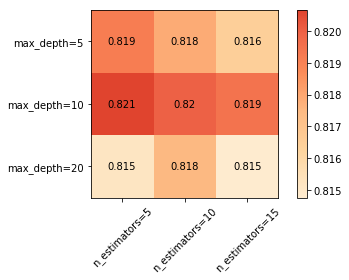

In [81]:
# changing numeric parameter without any restrictions
# in the rest of the parameter set

grid_search(grid_search_forest.cv_results_, change=('n_estimators', 'max_depth'), subset={'max_features': 10, 'bootstrap':True})
plt.show()

In [71]:
#find the best model of grid search
print(grid_search_forest.best_estimator_)

# Performance metrics
grid_best_train = grid_search_forest.best_estimator_.predict(x_train)
f_score_train = fbeta_score(y_train,grid_best_train,0.5)

grid_best_test = grid_search_forest.best_estimator_.predict(x_test)
f_score_test = fbeta_score(y_test,grid_best_test,0.5)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


             precision    recall  f1-score   support

        0.0       0.39      0.09      0.15       876
        1.0       0.80      0.96      0.88      3409

avg / total       0.72      0.78      0.73      4285



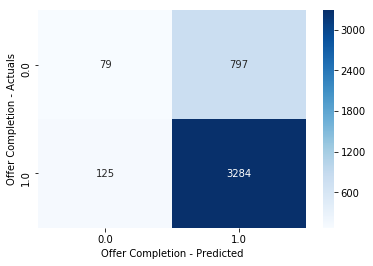

In [72]:
df_confusion = pd.crosstab(y_test, grid_best_test)
ax = sns.heatmap(df_confusion,cmap="Blues",annot=True,fmt="d")
ax.set(xlabel='Offer Completion - Predicted', ylabel='Offer Completion - Actuals')

print(classification_report(y_test, grid_best_test))

In [73]:
print()
print('The default model has Test fbeta-score -',round(f_score_test_baseline, 4))

print('The best model from grid-search Test fbeta-score -',round(f_score_test, 4))
print()
print('Thus with parameter tuning we gained a Test score improvement of -',round((f_score_test-f_score_test_baseline)*100,2),'%')


The default model has Test fbeta-score - 0.8086
The best model from grid-search Test fbeta-score - 0.8321

Thus with parameter tuning we gained a Test score improvement of - 2.35 %


In [74]:
def predict_offers(person_id, model):
    person = profile[profile['person_id'] == person_id]
    suggested_offers = []
    
    #Create a row of Customer-offer and predict the completion using the model. Do this for all offers in portfolio dataset
    for i in range(len(portfolio)):
        offer = portfolio[portfolio['offer_id'] == i]
        
        person_offer = pd.concat([person, offer],axis=1,join='outer',sort=True)
        
        person_offer = person_offer.fillna(method='bfill')
        person_offer = person_offer.fillna(method='ffill')
        person_offer = person_offer.drop_duplicates()
        offer_type = offer['offer_type']
        if offer_type.any() =='bogo':
            person_offer['offer_type_bogo']=1
            person_offer['offer_type_discount']=0
            person_offer['offer_type_informational']=0
        elif offer_type.any() == 'discount':
            person_offer['offer_type_bogo']=0
            person_offer['offer_type_discount']=1
            person_offer['offer_type_informational']=0
        else: #offer_type == 'informational':
            person_offer['offer_type_bogo']=0
            person_offer['offer_type_discount']=0
            person_offer['offer_type_informational']=1

        person_offer = person_offer.drop(['person_id','offer_id','age_bin','income_bin','offer_type'],
                                         axis=1)
        
        person_offer.replace({'gender': {'F':0, 'M':1}},inplace=True)

        person_offer = scaler.transform(person_offer)
                
        prediction = model.predict(person_offer)
        
        if prediction == 1:
            suggested_offers.append(i)
            
    return suggested_offers

In [75]:
def make_predictions(person_ids):
    df  = pd.DataFrame(columns=('person_id','gender','age','income','membership_years','offers_availed','offers_predicted'))

    with tqdm(total=len(person_ids)) as pbar:
        for person_id in person_ids:
            #Add a progress bar as this is a time consuming process
            pbar.update(1)
            predictions_train = obj.predict(x_train)
            
            # Get the demographic details, just for diplaying results of predicted offers for the customer
            person = profile[profile['person_id'] == person_id]
            df = df.append({'person_id':person_id, 
                        'gender':person['gender'].values[0],
                        'age':person['age'].values[0],
                        'income':person['income'].values[0],
                        'membership_years':person['membership_years'].values[0],
                        'offers_availed':(list(transcript[(transcript['person_id']==person_id) & (transcript['event']=='offer received') & (transcript['valid_offer_completion']==1)]['offer_id'])),
                        'offers_predicted':predict_offers(person_id,grid_search_forest.best_estimator_)},ignore_index=True)

    display(df)


In [76]:
# Get 50 Target Customers for prediction
person_ids = transcript_cust_type[transcript_cust_type['cust_type'] == 'target_customers']['person_id'].unique()

person_ids = person_ids[0:50]

make_predictions(person_ids)

100%|██████████| 50/50 [02:19<00:00,  2.86s/it]


,person_id,gender,age,income,membership_years,offers_availed,offers_predicted
0,0,M,33,72000.0,2.0,"[5.0, 3.0]","[0, 1, 2, 4, 5, 6, 7, 8, 9]"
1,1,F,59,90000.0,3.0,"[9.0, 4.0]","[1, 2, 4, 5, 7, 8, 9]"
2,4,F,19,65000.0,2.0,"[5.0, 9.0]","[1, 4, 5, 7, 8, 9]"
3,6,M,54,99000.0,3.0,"[9.0, 8.0, 8.0]","[0, 1, 2, 3, 4, 5, 7, 8, 9]"
4,8,M,54,91000.0,2.0,"[6.0, 3.0]","[0, 1, 2, 3, 4, 5, 7, 8, 9]"
5,10,F,28,68000.0,1.0,"[5.0, 3.0, 6.0]","[1, 2, 3, 4, 5, 7, 8, 9]"
6,11,M,26,61000.0,4.0,"[9.0, 2.0]","[1, 2, 4, 5, 7, 8, 9]"
7,17,M,55,83000.0,3.0,"[1.0, 1.0]","[0, 1, 2, 3, 4, 5, 7, 8, 9]"
8,19,M,72,102000.0,2.0,"[1.0, 1.0, 9.0]","[1, 4, 5, 7, 8, 9]"
9,20,M,62,80000.0,2.0,"[5.0, 9.0]","[1, 2, 4, 5, 7, 8, 9]"


In [77]:
#Identify customers who were not sent event a single offer
cust_with_no_offers = profile[~profile.person_id.isin(transcript_cust_type.person_id)]['person_id']

print(cust_with_no_offers.shape[0],'customers have not received any offers.')
      
#Confirm that these cust have not received any offer
print('Customers Should have only transaction data:',transcript[transcript['person_id'].isin(cust_with_no_offers)].event.unique())

5 customers have not received any offers.
Customers Should have only transaction data: ['transaction']


In [78]:
#Let's get predictions for these customers
make_predictions(cust_with_no_offers)

100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


,person_id,gender,age,income,membership_years,offers_availed,offers_predicted
0,11372,F,72,35000.0,1.0,[],"[1, 4, 5, 7, 8, 9]"
1,13454,F,66,34000.0,1.0,[],"[1, 2, 4, 5, 7, 8, 9]"
2,3297,F,55,88000.0,2.0,[],"[0, 1, 2, 3, 4, 5, 7, 8, 9]"
3,10060,F,54,72000.0,2.0,[],"[0, 1, 2, 3, 4, 5, 7, 8, 9]"
4,1054,M,91,70000.0,3.0,[],"[1, 2, 3, 4, 5, 7, 8, 9]"


In [83]:
#!!jupyter nbconvert *.ipynb